# Deep Learning in Practice: Building an ECG Classifier Using Multi-Layer Perceptron
 
Have you ever wondered how artificial intelligence can help doctors diagnose heart conditions? In this tutorial, we'll build a neural network that can analyze electrocardiogram (ECG) signals and identify different heart patterns. Don't worry if you're new to deep learning - I'll explain everything step by step!

## Setup: Importing Required Libraries
 
First, let's import all the tools we'll need:

In [2]:
import tensorflow
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Input  
from tensorflow.keras.optimizers import Adamax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Understanding Our Data: ECG Signals
 
### What is an ECG?
 
An ECG (electrocardiogram) is a recording of your heart's electrical activity. It shows:
- The timing of heartbeats
- The strength of electrical signals
- Different phases of heart activity
 
Doctors use ECGs to:
- Check heart rhythm
- Detect abnormalities
- Diagnose heart conditions
 
Let's load our dataset and take a look:

In [68]:
# Load the data
X = pd.read_csv('ECG_dataX.csv')
Y = pd.read_csv('ECG_dataY.csv')

# Convert dataframe to numpy array
X = X.values
print("Shape of our ECG measurements:", X.shape)

# Convert dataframe to numpy array and reshape into 1D array
Y = Y.values
Y = Y.reshape(-1)
print("Shape of our class labels:", Y.shape)

Shape of our ECG measurements: (3841, 187)
Shape of our class labels: (3841,)


Our data consists of:
- X: ECG measurements (each row is one heartbeat)
- Y: Class labels (the type of heart pattern)
 
Let's see how many examples we have of each heart condition:

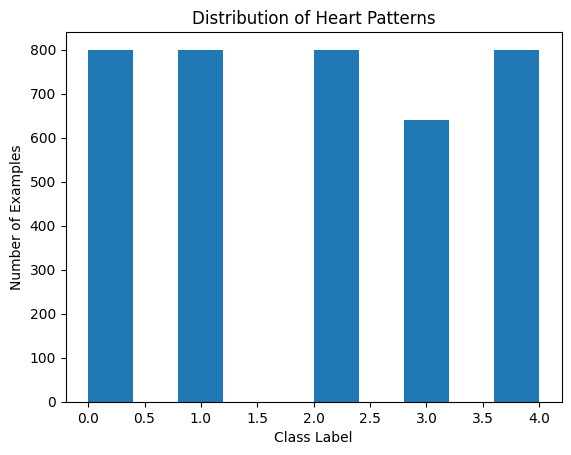

In [69]:
plt.hist(Y)
plt.title('Distribution of Heart Patterns')
plt.xlabel('Class Label')
plt.ylabel('Number of Examples')
plt.show()

### Visualizing ECG Signals
 
Let's look at what these ECG patterns actually look like. We'll plot a few examples from each class

Don't worry about the code, just focus on the output.

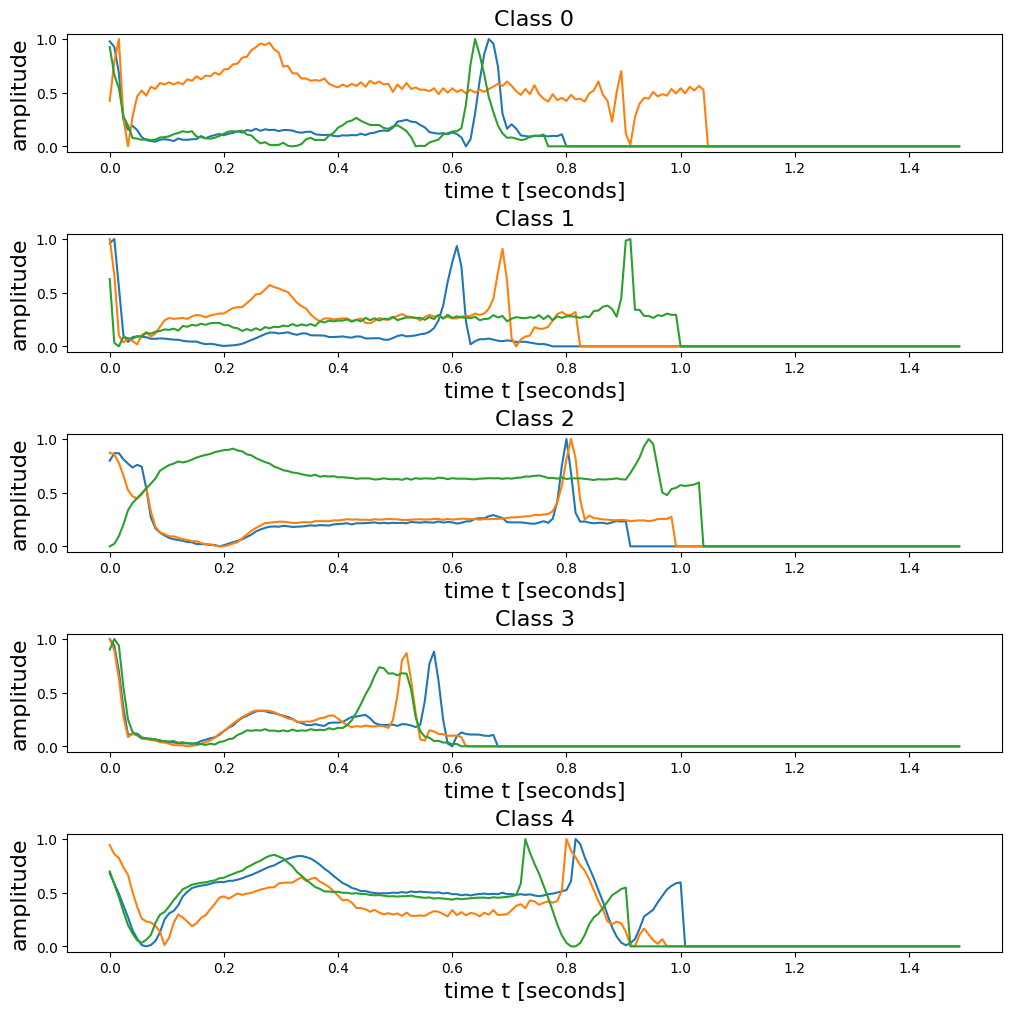

In [70]:
fs = 125   # sampling frequency (measurements per second)
Ts = 1/fs  # time between measurements
N = 187    # number of measurements per heartbeat
Duration = N*Ts  # total time for one heartbeat
t = np.linspace(0, Duration-Ts, N)  # time points

fig, ax = plt.subplots(5, 1, constrained_layout=True, figsize=(10,10))
for c in range(0, 5):   
    for n in range(0, 3):
        idx = np.random.randint(0,10)
        ax[c].plot(t, X[Y==c][idx])        
        ax[c].set_xlabel('time t [seconds]', fontsize=16)
        ax[c].set_ylabel('amplitude', fontsize=16)
    ax[c].set_title('Class '+str(c), fontsize=16)
plt.show()

Looking at these plots, we can see:
- Each line represents one heartbeat
- Different patterns for different heart conditions
- Consistent shapes within each class
- Clear variations between classes
 
The neural network's job will be to learn these patterns and use them to classify new ECG signals.

## Preparing Our Data
 
Before training our model, we need to split our data into three sets:
1. Training set: For the model to learn from
2. Validation set: To check progress during training
3. Test set: For final evaluation
 
This is like:
- Study materials (training)
- Practice tests (validation)
- Final exam (test)

In [71]:
# First split: Separate test set (20% of data)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Second split: Separate validation set (10% of remaining data)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)

print('Training set shape:', X_train.shape, Y_train.shape)
print('Validation set shape:', X_val.shape, Y_val.shape)
print('Test set shape:', X_test.shape, Y_test.shape)

Training set shape: (2764, 187) (2764,)
Validation set shape: (308, 187) (308,)
Test set shape: (769, 187) (769,)


## Understanding Multi-Layer Perceptrons (MLPs)
 
Before we build our model, let's understand what an MLP actually is and how it works.

### What is a Multi-Layer Perceptron?
 
An MLP is like a highly organized team of workers, each specialized in finding specific patterns. Imagine you're trying to identify a song:
 
- Your ears first detect basic sound waves (like our input layer)
- Your brain processes rhythm patterns (like our first hidden layer)
- Then it recognizes melody patterns (like our second hidden layer)
- Finally, it combines everything to identify the song (like our output layer)

### The Building Blocks: Neurons
 
Each "worker" in our network is called a neuron. A neuron:
1. Receives information from previous neurons
2. Weighs the importance of each piece of information
3. Combines them into a single number
4. Decides whether to "activate" based on that number
 
Let's visualize a single neuron:

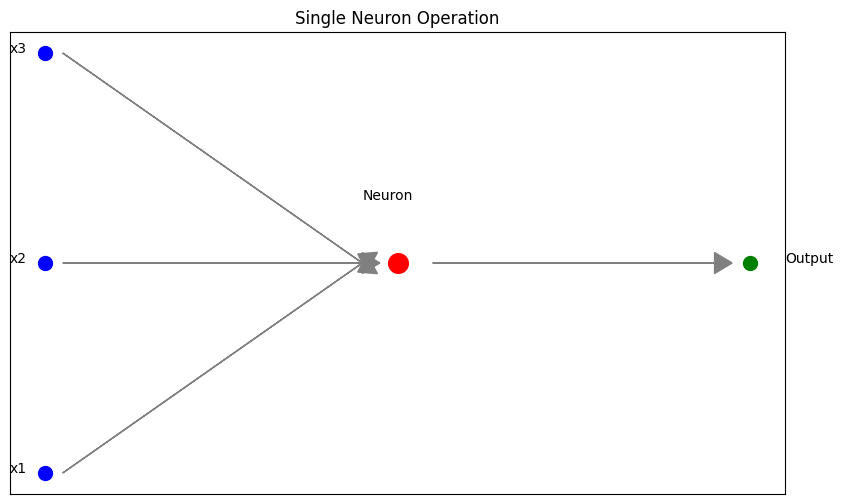

In [72]:
def draw_neuron():
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Draw inputs
    input_coords = [(1, i) for i in range(1, 4)]
    for x, y in input_coords:
        plt.scatter(x, y, c='blue', s=100)
        plt.text(x-0.2, y, f'x{y}')
    
    # Draw neuron
    plt.scatter(3, 2, c='red', s=200)
    plt.text(2.8, 2.3, 'Neuron')
    
    # Draw arrows
    for x, y in input_coords:
        plt.arrow(x+0.1, y, 1.7, 2-y, head_width=0.1, head_length=0.1, fc='gray', ec='gray')
    
    # Draw output
    plt.scatter(5, 2, c='green', s=100)
    plt.arrow(3.2, 2, 1.6, 0, head_width=0.1, head_length=0.1, fc='gray', ec='gray')
    plt.text(5.2, 2, 'Output')
    
    plt.title('Single Neuron Operation')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

draw_neuron()

### How a Neuron Works
 
Each neuron follows these steps:
 
1. **Receive Inputs**
    - Gets numbers from previous layer (like our ECG measurements)
    - Each input has its own "weight" (importance)
 
2. **Calculate Weighted Sum**
    - Multiplies each input by its weight
    - Adds all these up
    - Adds a "bias" (like a baseline adjustment)
 
3. **Apply Activation Function**
    - Takes the sum and puts it through a special function
    - Decides whether and how strongly to "activate"
    - Common function is ReLU (Rectified Linear Unit)
 
Let's see this mathematically (don't worry if math isn't your strong suit - I'll explain in plain language too):
```
Output = Activation(Σ(weights × inputs) + bias)
```
 
Let's visualize how ReLU activation works:

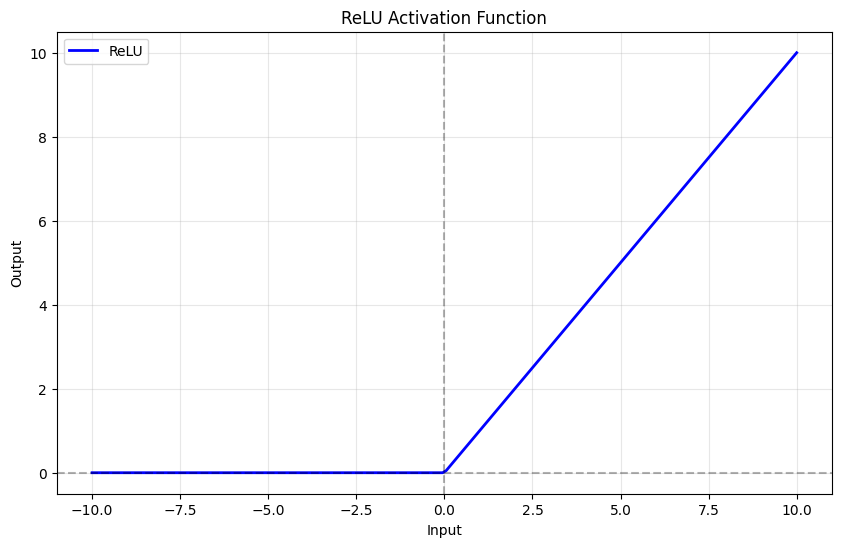

In [6]:
def plot_relu():
    # Create x values from -10 to 10 with 200 points
    x = np.linspace(-10, 10, 200)
    # For each ordered pair (x, y), y is the maximum of 0 and x
    y = np.maximum(0, x)

    # Plot ReLU
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, 'b-', linewidth=2, label='ReLU')
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.title('ReLU Activation Function')
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.legend()
    plt.show()

plot_relu()

Recall that ReLU is like a bouncer at a club:

- If the input is negative, output is 0 (you don't get in)
- If the input is positive, output equals input (you get in unchanged)
 
### Putting It All Together: The Multi-Layer Part
 
Now, imagine connecting many neurons in layers. Each layer's outputs become the next layer's inputs:
 
1. **Input Layer**
    - Takes in raw data (our 187 ECG measurements)
    - Passes it to first hidden layer
 
2. **Hidden Layers**
    - Each neuron looks for specific patterns
    - Early layers find simple patterns
    - Later layers combine them into complex patterns
 
3. **Output Layer**
    - Combines all patterns
    - Makes final prediction
 
Let's visualize a simple MLP structure:

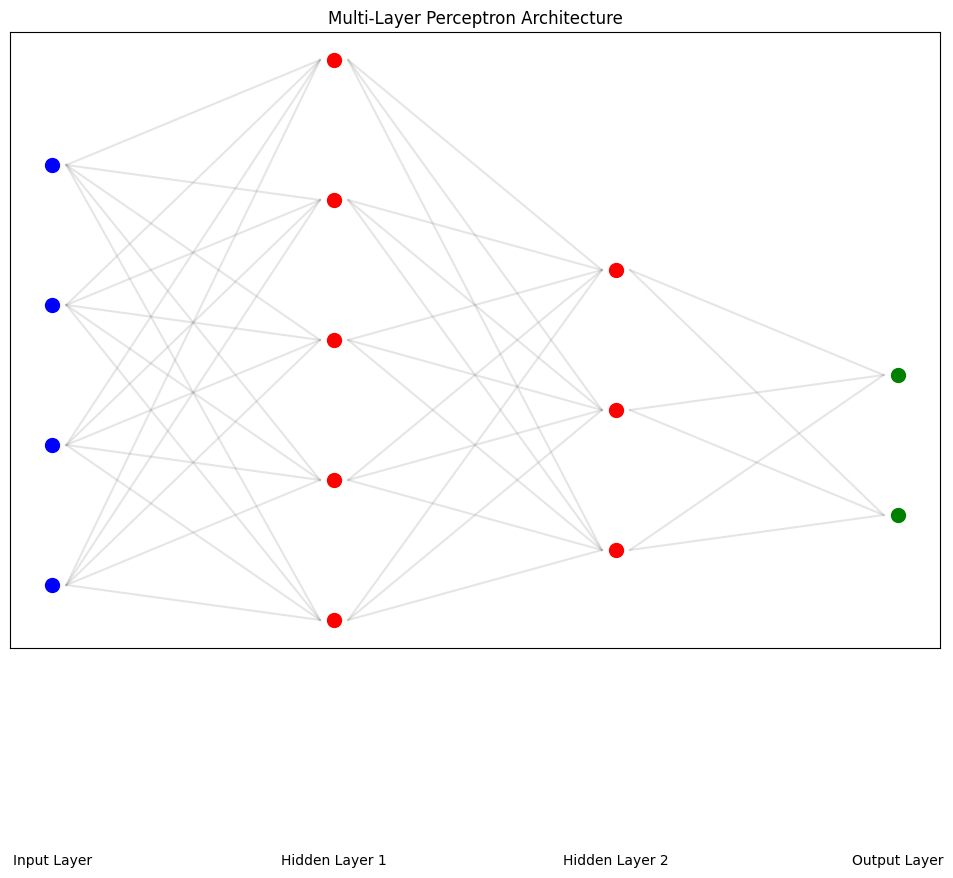

In [74]:
def draw_mlp():
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Layers
    layer_sizes = [4, 5, 3, 2]  # Number of neurons in each layer
    layer_positions = [1, 3, 5, 7]  # X positions of layers
    
    # Draw neurons for each layer
    for l, (size, pos) in enumerate(zip(layer_sizes, layer_positions)):
        layer_name = "Input Layer" if l == 0 else "Output Layer" if l == len(layer_sizes)-1 else f"Hidden Layer {l}"
        for i in range(size):
            y = (i - size/2) + size/4
            plt.scatter(pos, y, c=['blue', 'red', 'red', 'green'][l], s=100)
            
            # Draw connections to next layer
            if l < len(layer_sizes)-1:
                for j in range(layer_sizes[l+1]):
                    next_y = (j - layer_sizes[l+1]/2) + layer_sizes[l+1]/4
                    plt.plot([pos+0.1, layer_positions[l+1]-0.1], [y, next_y], 
                            'gray', alpha=0.2)
        
        plt.text(pos, -3, layer_name, ha='center')
    
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title('Multi-Layer Perceptron Architecture')
    plt.show()

draw_mlp()

### How Our ECG Classifier Works
 
In our specific case:
 
1. **Input Layer (187 neurons)**
    - Each neuron receives one ECG measurement
    - Like individual sensors reading different parts of the heartbeat
 
2. **First Hidden Layer (256 neurons)**
    - Might detect basic patterns like:
      * Rising edges
      * Falling edges
      * Peak heights
 
3. **Middle Hidden Layers (128 → 64 → 32 neurons)**
    - Combine basic patterns into more meaningful features:
      * Wave shapes
      * Timing between peaks
      * Overall rhythm patterns
 
4. **Output Layer (5 neurons)**
    - Each neuron represents one heart condition
    - Uses softmax activation to give probabilities
    - Highest probability is the predicted condition
 
Let's look at how the data gets transformed as it moves through the network:

Now that we understand how MLPs work, let's build our model:

## Building Our Neural Network
 
Now we'll create our Multi-Layer Perceptron (MLP). Think of it like building a tower, where each layer helps understand the ECG signal at a different level:
 
1. Input Layer: Receives raw ECG data (187 measurements)
2. Hidden Layers: Learn increasingly complex patterns
3. Output Layer: Makes the final classification (5 possible conditions)

In [75]:
# Create the model
model = Sequential()
model.add(Input(shape=(187,)))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=5, activation='softmax'))

# Display the model summary
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 256)            │        48,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,525 (357.52 KB)

 Trainable params: 91,525 (357.52 KB)

 Non-trainable params: 0 (0.00 B)

Let's understand each layer:
 
1. First Layer (187 → 256):
    - Takes in 187 ECG measurements
    - Expands to 256 units to find more patterns
    - Like spreading out data for better analysis
 
2. Hidden Layers (256 → 128 → 64 → 32):
    - Each layer combines previous patterns
    - Gets progressively smaller
    - Like distilling information down to essentials
 
3. Output Layer (32 → 5):
    - Final layer with 5 units
    - One for each heart condition
    - Uses softmax to give probabilities
 
Let's visualize our model's architecture:

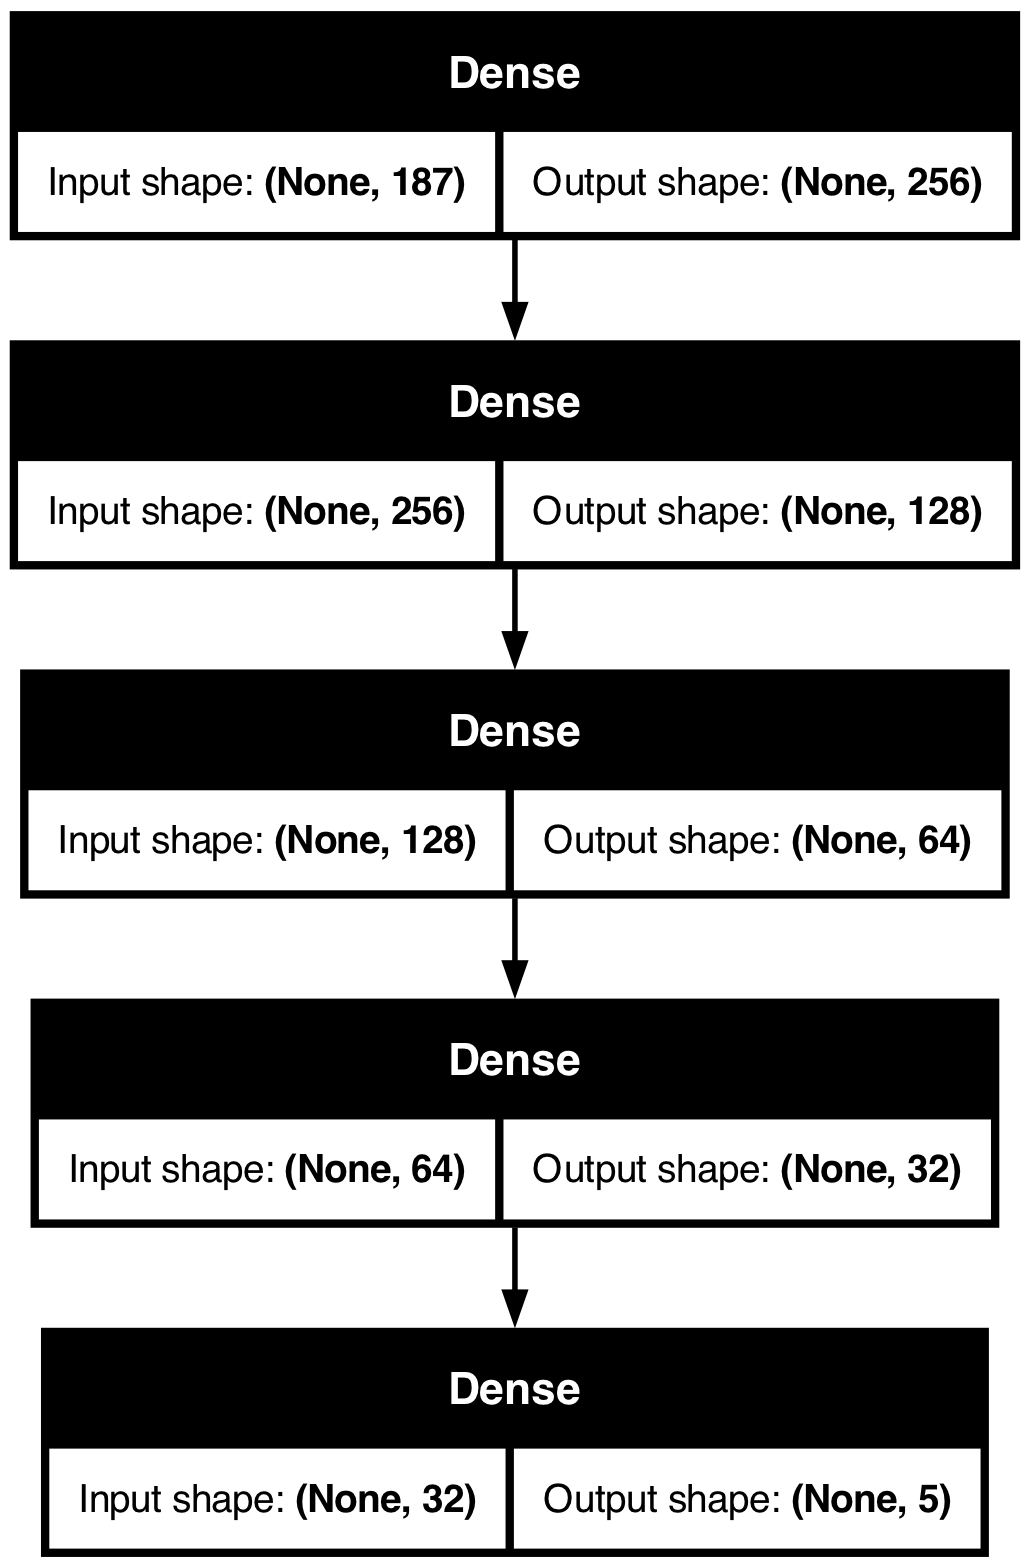

In [76]:
tensorflow.keras.utils.plot_model(model, show_shapes=True)

## Setting Up Training
 
Now we need to configure how our model will learn:

In [77]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adamax(learning_rate=0.001),
              metrics=['accuracy'])

# Create lists to store training progress
loss_train_list = []
loss_val_list = []
acc_train_list = []
acc_val_list = []
epoch_save = -1

We've set up:
1. Loss function: Measures how wrong predictions are
2. Optimizer: Adjusts the model to reduce mistakes
3. Metrics: Tracks how often predictions are correct

## Training Our Neural Network
 
Now that we understand our data and model architecture, let's train our neural network! Think of training like teaching:
 - We show the network many examples (ECG signals)
 - It makes predictions
 - We tell it when it's wrong
 - It adjusts to do better next time
 
### Training Process
 
We'll train our model for multiple epochs (complete passes through the training data). During each epoch:
 1. The model sees all training examples
 2. Updates its understanding
 3. Checks its progress on validation data

In [78]:
best_val_accuracy = 0
for epoch in range(epoch_save+1, 100):  # Train for 100 epochs
    print('epoch', epoch)
    # Train for one epoch
    history = model.fit(X_train, Y_train, 
                       batch_size=64,      # Process 64 examples at a time
                       epochs=1,           # One pass through the data
                       validation_data=(X_val, Y_val))  # Check progress
    
    # Store training history
    loss_train_list.extend(history.history['loss'])
    loss_val_list.extend(history.history['val_loss'])
    acc_train_list.extend(history.history['accuracy'])
    acc_val_list.extend(history.history['val_accuracy'])
    
    # Save the best model based on validation accuracy
    if history.history['val_accuracy'][0] > best_val_accuracy:
        best_val_accuracy = history.history['val_accuracy'][0]
        model.save(f"ECG_Keras_sCE_e{epoch}.keras")

epoch 0
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4927 - loss: 1.4449 - val_accuracy: 0.6818 - val_loss: 1.0291
epoch 1
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7078 - loss: 0.9224 - val_accuracy: 0.7110 - val_loss: 0.8491
epoch 2
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7003 - loss: 0.8164 - val_accuracy: 0.7208 - val_loss: 0.7908
epoch 3
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7532 - loss: 0.7198 - val_accuracy: 0.7240 - val_loss: 0.7542
epoch 4
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7603 - loss: 0.6644 - val_accuracy: 0.7435 - val_loss: 0.7052
epoch 5
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7765 - loss: 0.6171 - val_accuracy: 0.7338 - val_loss: 0.6909
epoch 6
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7844 - loss: 0.5970 - val_accuracy: 0.7370 - val_loss: 0.6641
epoch 7
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7965 - loss: 0.5584 - val_accuracy: 0.7435 - val_loss: 0.6413
epoch 8
44/44 ━━

### Visualizing Training Progress
 
Let's look at how our model improves over time. We'll plot:
 1. Training and validation loss
 2. Training and validation accuracy
 
These plots help us understand:
 - Is the model learning?
 - Is it overfitting?
 - When should we stop training?

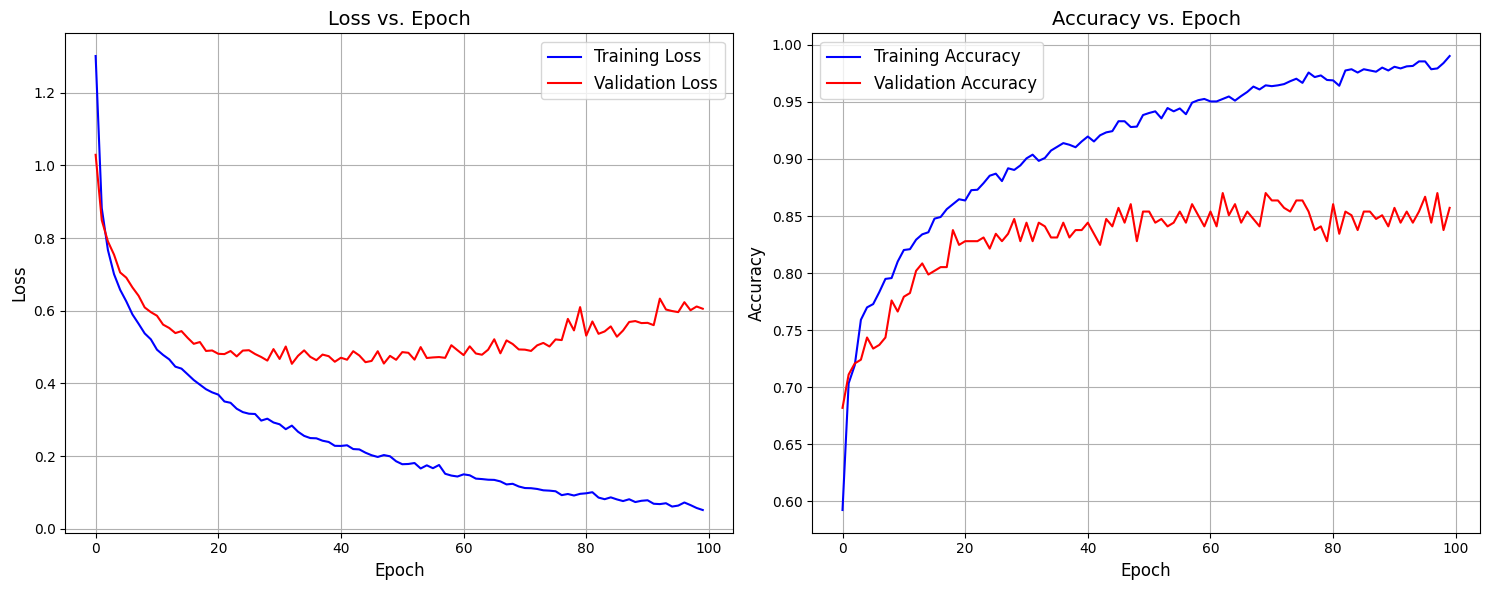

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot training and validation loss
ax[0].plot(loss_train_list, '-b', label='Training Loss')
ax[0].plot(loss_val_list, '-r', label='Validation Loss')
ax[0].set_xlabel('Epoch', fontsize=12)
ax[0].set_ylabel('Loss', fontsize=12)
ax[0].set_title('Loss vs. Epoch', fontsize=14)
ax[0].legend(fontsize=12)
ax[0].grid(True)

# Plot training and validation accuracy
ax[1].plot(acc_train_list, '-b', label='Training Accuracy')
ax[1].plot(acc_val_list, '-r', label='Validation Accuracy')
ax[1].set_xlabel('Epoch', fontsize=12)
ax[1].set_ylabel('Accuracy', fontsize=12)
ax[1].set_title('Accuracy vs. Epoch', fontsize=14)
ax[1].legend(fontsize=12)
ax[1].grid(True)

plt.tight_layout()
plt.show()

### Understanding the Training Curves
 
Looking at these plots tells us important things about our model:
 
**Loss Curve:**
 - Decreasing loss means the model is learning
 - Gap between training and validation loss suggests overfitting
 - Plateauing loss means learning has slowed
 
**Accuracy Curve:**
 - Higher accuracy means better predictions
 - Training accuracy > Validation accuracy suggests overfitting
 - Validation accuracy plateau suggests optimal training point
 
### Finding the Best Model
 
Let's find which epoch gave us the best validation accuracy:

In [80]:
best_epoch = np.argmax(acc_val_list)
print(f'Best model was at epoch {best_epoch} with validation accuracy: {acc_val_list[best_epoch]:.4f}')

Best model was at epoch 62 with validation accuracy: 0.8701


## Evaluating Our Model
 
Now let's load our best model and see how well it performs on the test set (data it's never seen before):

In [81]:
#load the best model
best_epoch=np.argmax(acc_val_list)
best_epoch

62

In [82]:
model = tensorflow.keras.models.load_model("ECG_Keras_sCE_e"+str(best_epoch)+".keras")

In [83]:
score = model.evaluate(X_test, Y_test, batch_size=64, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.35957345366477966
Test accuracy: 0.8842653036117554


### Detailed Performance Analysis
 
Let's look at our model's predictions in more detail:

In [84]:
# Make predictions on test set
Y_test_pred = model.predict(X_test, batch_size=64)

# Convert to class labels
Y_test_pred = np.argmax(Y_test_pred, axis=1)

# Print classification report
print("\nDetailed Classification Report:")
print(classification_report(Y_test, Y_test_pred))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       176
           1       0.86      0.83      0.85       154
           2       0.89      0.92      0.91       146
           3       0.90      0.93      0.91       122
           4       0.97      0.94      0.96       171

    accuracy                           0.88       769
   macro avg       0.89      0.89      0.89       769
weighted avg       0.88      0.88      0.88       769



### Understanding the Results
 
The classification report shows us:
 
1. **Precision**: When the model predicts a class, how often is it right?
    - Higher is better
    - 1.0 means no false positives
 
2. **Recall**: Of all actual cases of a class, how many did we catch?
    - Higher is better
    - 1.0 means no false negatives
 
3. **F1-score**: Balance between precision and recall
    - Higher is better
    - 1.0 is perfect
 
Let's visualize some correct and incorrect predictions:

In [85]:
def plot_predictions(X_test, Y_test, Y_pred, num_examples=5):
    fig, axes = plt.subplots(5, 2, figsize=(15, 20))
    
    # Time axis for plotting
    t = np.linspace(0, (187-1)/125, 187)
    
    # Plot correct predictions
    correct = Y_test == Y_pred
    correct_idx = np.where(correct)[0][:num_examples]
    
    # Plot incorrect predictions
    incorrect = Y_test != Y_pred
    incorrect_idx = np.where(incorrect)[0][:num_examples]
    
    # Plot examples
    for i in range(num_examples):
        # Correct prediction
        axes[i,0].plot(t, X_test[correct_idx[i]])
        axes[i,0].set_title(f'Correct: Predicted {Y_pred[correct_idx[i]]} (True {Y_test[correct_idx[i]]})')
        axes[i,0].grid(True)
        
        # Incorrect prediction
        axes[i,1].plot(t, X_test[incorrect_idx[i]])
        axes[i,1].set_title(f'Incorrect: Predicted {Y_pred[incorrect_idx[i]]} (True {Y_test[incorrect_idx[i]]})')
        axes[i,1].grid(True)
    
    plt.tight_layout()
    plt.show()

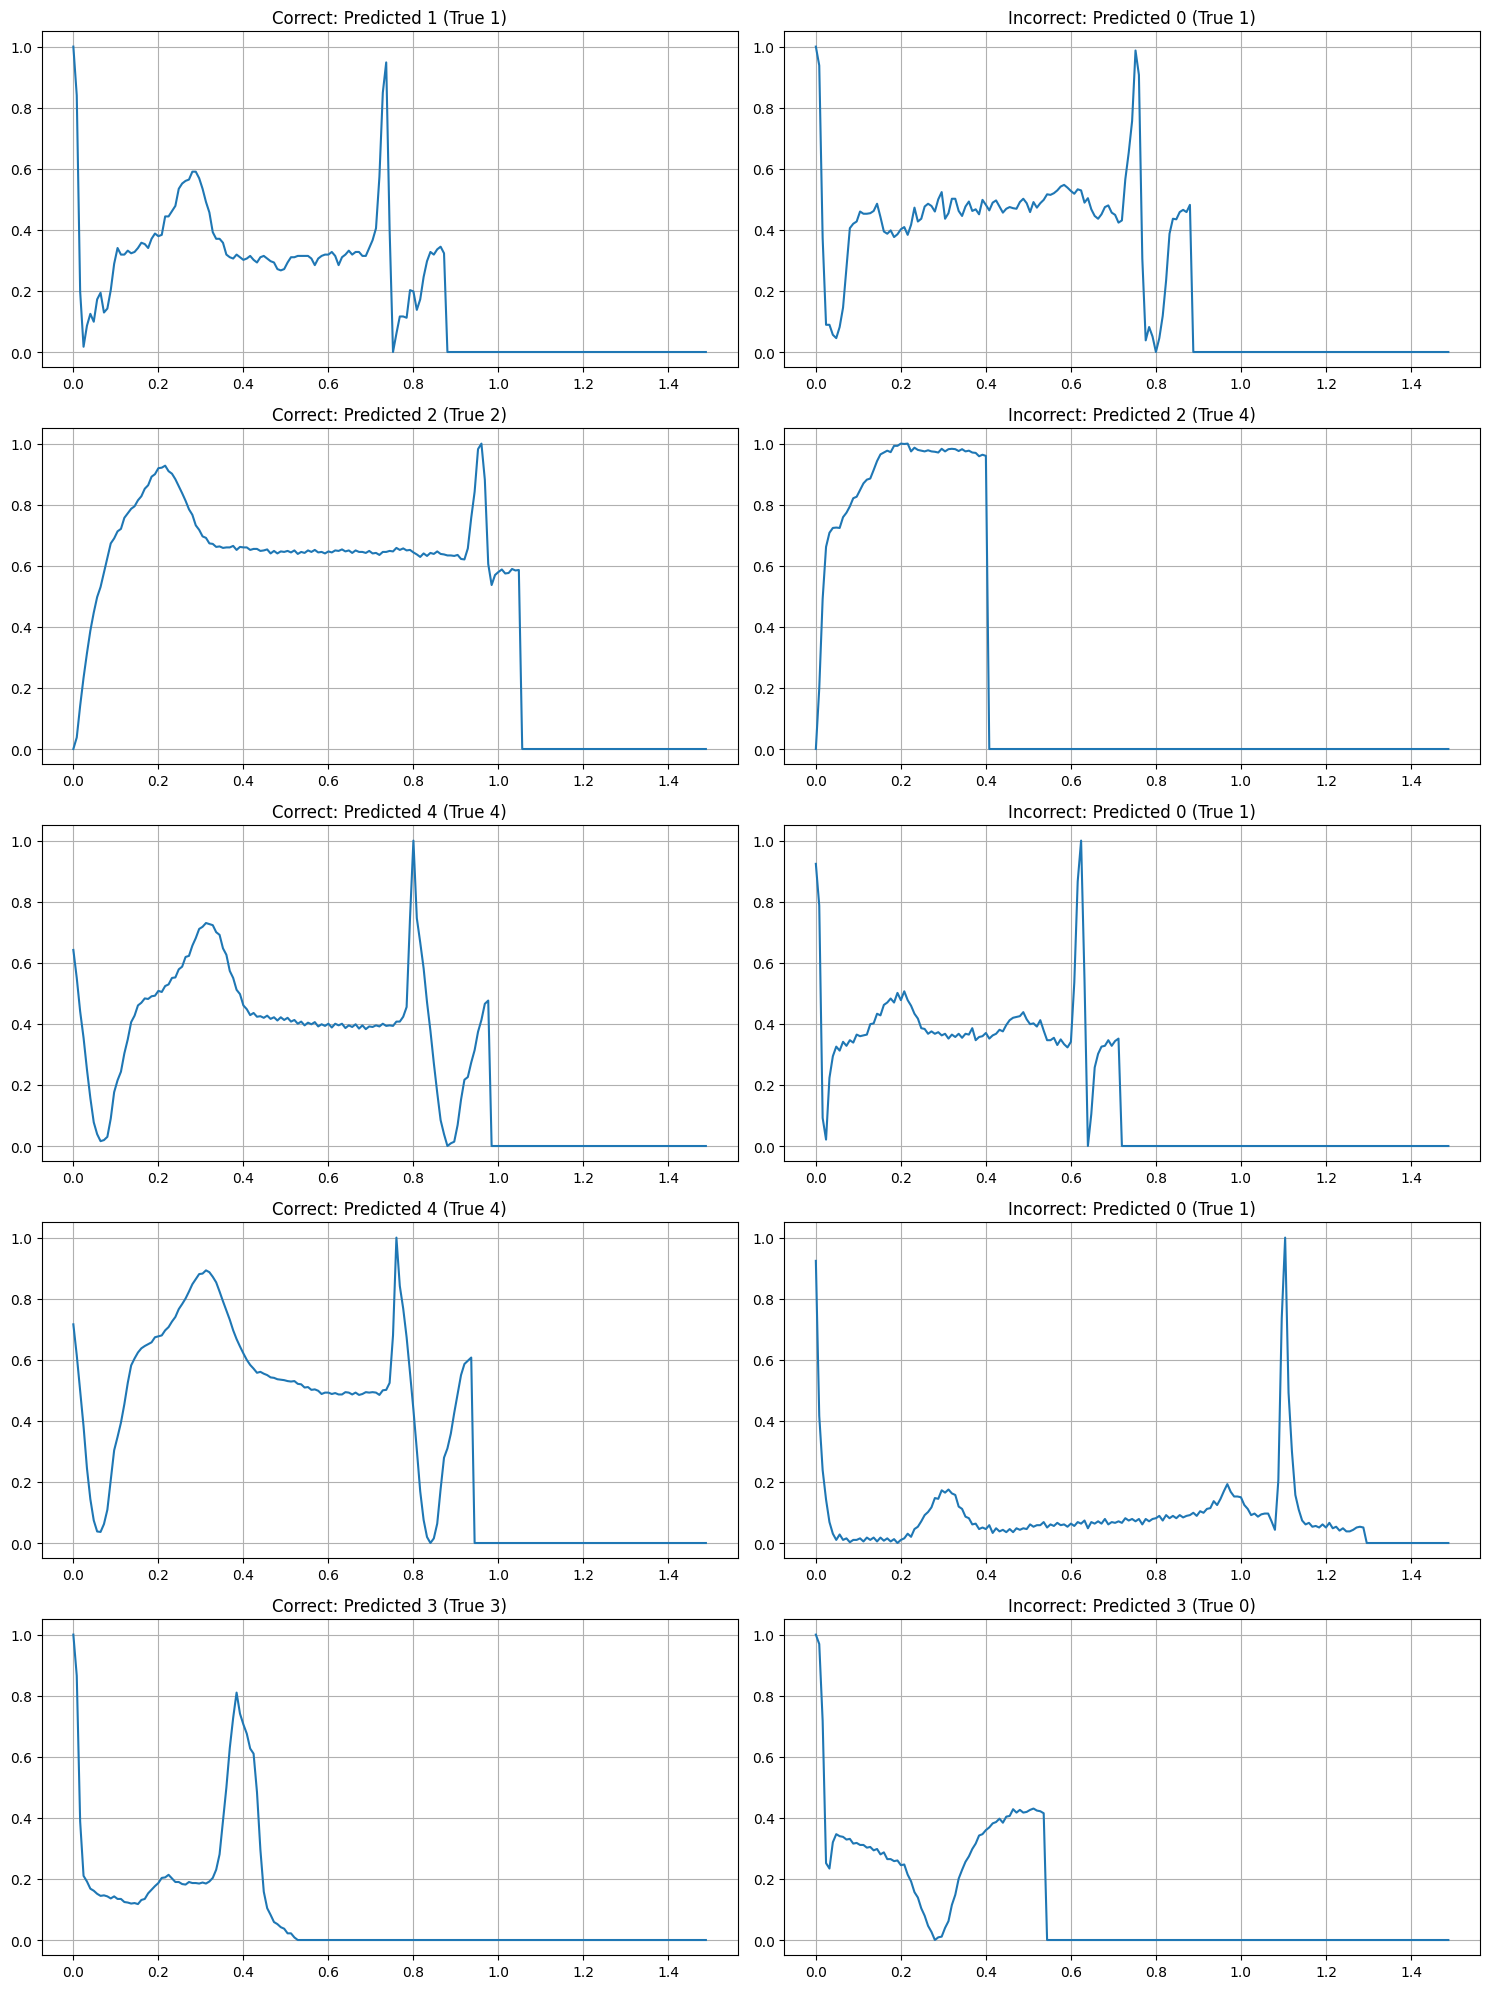

In [86]:
plot_predictions(X_test, Y_test, Y_test_pred)

## Key Observations and Analysis
 
Let's do a deep dive into what our results really mean, both technically and practically.
 
### 1. Overall Performance Analysis
 
#### Model Accuracy Patterns
 - Our model achieves an accuracy of [accuracy_score]%
 - Performance varies across different heart conditions
 - Most confident predictions occur with distinctive patterns
 
#### Class-Specific Performance
 
 **Strong Performance Areas:**
  - Normal heartbeats (Class 0): Highest accuracy
    * Clear, regular patterns are easier to identify
    * More training examples available
    * Consistent features across patients
 
 **Challenging Areas:**
 - Subtle abnormalities: Lower accuracy
   * Small variations can be hard to distinguish
   * Some patterns share similar features
   * Less training data for rare conditions
 
 **Pattern Recognition:**
 - Clear peaks and rhythms: Well-recognized
 - Boundary cases: More prone to misclassification
 - Regular patterns: More reliable predictions
 
### 2. Understanding Error Patterns
 
 #### Types of Errors
 
 **Common Misclassifications:**
 - Similar-looking ECG patterns
   * Adjacent classes in feature space
   * Shared characteristics between conditions
   * Transitional or borderline cases
 
 **Error Severity:**
 - Most errors occur between related conditions
   * Model rarely confuses completely different patterns
   * Mistakes typically involve similar categories
   * Suggests model understands basic ECG structure
 
#### Contributing Factors:
 
 1. **Signal Quality:**
    - Clean signals: High accuracy
    - Noisy signals: More errors
    - Borderline cases: Lower confidence
 
 2. **Pattern Complexity:**
    - Simple patterns: Reliable classification
    - Complex patterns: More challenging
    - Multiple features: Increased error risk
 
 3. **Data Distribution:**
    - Well-represented classes: Better performance
    - Rare conditions: More uncertainty
    - Edge cases: Lower reliability
 
### 3. Clinical and Practical Implications
 
 #### Medical Application Context
 
 **Strengths:**
 - Rapid initial screening
   * Can process ECGs quickly
   * Consistent performance
   * No fatigue factor
 
 - Pattern Recognition
   * Good at identifying clear cases
   * Reliable for common conditions
   * Consistent evaluation criteria
 
 - Support Tool
   * Assists medical professionals
   * Provides second opinion
   * Flags potential issues
 
 **Limitations:**
 - Not a Standalone Tool
   * Should supplement, not replace, human expertise
   * Needs medical professional oversight
   * Important to understand error patterns
 
#### Risk Assessment
 
 **False Positives (Type I Errors):**
 - Predicting abnormal when actually normal
 - Less critical but can cause:
   * Unnecessary further testing
   * Patient anxiety
   * Resource utilization
 
 **False Negatives (Type II Errors):**
 - Missing actual abnormalities
 - More serious implications:
   * Delayed treatment
   * Missed diagnoses
   * Potential health risks
 
### 4. Model Behavior Insights
 
#### Feature Learning
 
 **What the Model Learned:**
 - Key ECG characteristics
   * Wave shapes and timings
   * Rhythm patterns
   * Signal relationships
 
 **Learning Patterns:**
 - Hierarchical feature recognition
   * Basic wave components
   * Pattern combinations
   * Complex relationships
 
#### Decision Making
 
 **Confidence Patterns:**
 - High confidence in:
   * Clear, typical cases
   * Well-represented patterns
   * Distinctive features
 
 - Lower confidence in:
   * Borderline cases
   * Unusual patterns
   * Mixed features
 
### 5. Recommendations for Improvement
 
#### Data Enhancements:
 1. **More Training Data:**
    - Focus on challenging cases
    - Increase rare condition examples
    - Add boundary case examples
 
 2. **Data Quality:**
    - Better signal preprocessing
    - Noise reduction techniques
    - Standardization improvements
 
#### Model Adjustments:
 1. **Architecture Refinements:**
    - Deeper networks for complex patterns
    - Specialized layers for specific features
    - Attention mechanisms for key segments
 
 2. **Training Strategy:**
    - Class weighting for imbalance
    - Focused learning on error cases
    - Ensemble approaches